In [1]:
from vectorbtpro import *

from datetime import datetime
from dateutil.relativedelta import relativedelta

from pypfopt.objective_functions import transaction_cost
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientFrontier

In [2]:
vbt.settings.set_theme("dark")

# Portfolio Optimization

Financial markets are highly nondeterministic. We want to find the portfolio that offers us high returns at low risk under the following market assumptions.
1. Rational decision-makers: Investors want to maximise return while reducing the risks associated with their investment
2. **No arbitrage** : cannot make a costless, riskless profit
3. Risky securities : $\{S_1,\ldots,S_n\}:\, n\geq 2$ be risky securities whose future returns are uncertain. There is no risk-free asset $S_0$ in our portfolio
4. Equilibrium : supply equals demand for securities
5. Liquidity : any # of units of a security can be bought and sold quickly
6. Access to information : rapid availability of accurate information
7. **Price is efficient** : Price of security adjusts immediately to new information, and current price reflects past information and expected
further behaviour
8. No transaction costs and taxes : transaction costs are assumed to be negligible compared to value of trades (*we may relax this assumption and assume cost* $K$ *per transaction*) and are ignored. No taxes (capital-gains etc.) on transactions.

We want to select a portfolio $\mathbf{x}=(x_1,\ldots,x_n)\in\mathbb{R}^n$ where $x_i$ is the amount (fraction of budget) invested in security $S^i$. We work in **discrete-time**, so we only consider now ($t=0$) and a moment in time in the future ($t=1$)

The return of asset $i$ is a random variable $r_i:\Omega \rightarrow [0,\infty)$ where $\Omega$ is the sample space (set of scenarios for the future). If $S_t^i:\Omega\rightarrow\mathbb{R}_+$ is the random variable denoting the future value of asset $i$ at time $t$. 
Then under scenario $\omega\in\Omega$, we have that $r_i(\omega)=S^i_1(\omega)/S_0^i$. So for instance, a $5\%$ return on asset $i$ corresponds to $r_i=1.05$ and $-2%$ return corresponds to $r_i=0.98$

$\newcommand{\x}{\mathbf{x}}$
Let $r = (r_1,\ldots, r_n)$ denote the random vector of returns with mean $\mu=\mathbf{E}[r]\in\mathbb{R}^n$ and covariance matrix $\Sigma\in\mathbb{R}^{n\times n}$. Let the set of admissible portfolios be denoted by $X=\{\x\in\mathbb{R}^n:\sum_{i=0}^n x_i=1,\, \x\geq 0\}\subset\mathbb{R}^n$. In other words, we do not allow short-selling (for now), and must always be fully-allocated.

Then the **return of portfolio** $\mathcal{R}:X\rightarrow \mathbb{R}$ is given by $\mathcal{R}(\x)=r^T\x \implies \mathbf{E}[\mathcal{R}] = \mu^T\x$. 

The **risk of portfolio** $\x\in X$ is denoted $\text{Risk}(\x)\equiv\text{Risk}(\mathcal{R}(\x))$ where $\text{Risk}:X\rightarrow\mathbb{R}$ is the risk measure.

<span style="display: inline-flex; align-items: center; gap: 5%;">
<img src="images/index-finger-hand-pointing-clip-art.png" style="height: 20px; width: 40px;">
<div style="font-weight: bold; font-size: 15px;"> Disclaimer</div>
</span>

We will be using [vector-bt](https://github.com/polakowo/vectorbt), a (semi-)professional vectorized backtesting library written in Python. The author, Oleg Polakow, offers a "premium" version of the library, which unlocks everything we will be needing, however it costs $25/mo. Please let me know if you want to run this notebook I can clone the premium repo to your machine with my github credentials. Or if you like Oleg's work you can pay him directly too (:
I also acknowledge that most of the mathematical modeling comes from Prof. Gupte's slides.

### Data Fetching

In [3]:
END_DATE = datetime.today().strftime("%Y-%m-%d")
START_DATE = (datetime.today() - relativedelta(years=3)).strftime("%Y-%m-%d")

In [4]:
data = vbt.BinanceData.pull(
    ["BTCUSDT", "ETHUSDT", "SOLUSDT", "ADAUSDT"], 
    start=f"{START_DATE} UTC", 
    end=f"{END_DATE} UTC",
    timeframe="1d"
)

#data.to_hdf("data/BinanceData.h5") # save data to disk
#data = vbt.HDFData.pull("data/BinanceData.h5") # retrieve data from disk

 25%|##5       | 1/4 [00:02<00:07,  2.66s/it, symbol=ETHUSDT]

2it [00:02,  1.02s/it, 2023-02-03 → 2026-02-02]

The object returned inherits from the `vectorbtpro.data` base class, which is very extensible, but for modeling purposes we only really care about OHLC data.

In [5]:
df = data.get("close")
df.tail()

symbol,BTCUSDT,ETHUSDT,SOLUSDT,ADAUSDT
Open time,,,,
2026-01-29 00:00:00+00:00,84650.16,2822.59,117.82,0.3347
2026-01-30 00:00:00+00:00,84260.49,2707.38,117.59,0.3208
2026-01-31 00:00:00+00:00,78741.09,2451.95,105.58,0.2936
2026-02-01 00:00:00+00:00,76968.21,2270.15,100.79,0.2858
2026-02-02 00:00:00+00:00,78738.61,2347.02,104.55,0.2991


$\newcommand{\x}{\mathbf{x}}$
$\newcommand{\R}{\mathbb{R}}$

We want to maximize expected return while minimizing risk

<span style="flex-center"><img src="images/risk-return.png" alt="optimizing risk-return tradeoff" width=500></span>

Here we consider the risk-return trade-off:$\quad \max\; \{\mu^T\x -\delta\text{Risk}(x)\, |\, \x\in X \}\quad \text{where}\quad X=\{\x\in(-1,1)^n\, |\, \x^T\mathbf{1}=1 \}$

In [6]:
def mean_var(x, mu, cov_matrix, delta):
    var = x.T @ (cov_matrix * np.eye(cov_matrix.shape[0])) @ x
    return -((mu.T @ x) - delta * var)

def optimize_func(price, index_slice):
    price_filt = price.iloc[index_slice]
    mu = mean_historical_return(price_filt)
    S = CovarianceShrinkage(price_filt).ledoit_wolf()
    ef = EfficientFrontier(mu, S, weight_bounds=(0.01, 0.3))
    ef.convex_objective(mean_var, mu=mu.values, cov_matrix=S.values, delta=0.01)
    weights = ef.clean_weights()
    return weights

In [7]:
pfo = vbt.PortfolioOptimizer.from_optimize_func(
    data.symbol_wrapper,
    optimize_func,
    data.get("Close"),
    vbt.Rep("index_slice"),
    every="M"
)
pf = pfo.simulate(data, freq="1d")

In [8]:
pf.stats()

Start Index                     2023-02-03 00:00:00+00:00
End Index                       2026-02-02 00:00:00+00:00
Total Duration                         1096 days 00:00:00
Start Value                                         100.0
Min Value                                       80.433701
Max Value                                       467.09985
End Value                                      222.388976
Total Return [%]                               122.388976
Benchmark Return [%]                           143.660344
Position Coverage [%]                            94.79927
Max Gross Exposure [%]                              100.0
Max Drawdown [%]                                54.018938
Max Drawdown Duration                   250 days 00:00:00
Total Orders                                          140
Total Fees Paid                                       0.0
Total Trades                                           78
Win Rate [%]                                     70.27027
Best Trade [%]

$\newcommand{\x}{\mathbf{x}}$
We choose to maximize the sharpe ratio which $S_a=\mathbf{E}[R^i-R^0]/\sqrt{\mathbf{V}[R^i-R^0]}$ where $R^0$ is the risk-free asset return (like the U.S treasury bond - it has essentially no risk - backed by US military / country's stability, this could also be the interest gained by making a bank deposit) and $R^i$ is asset $i$'s return. The portfolio with maximum sharpe ratio is the tangency portfolio.

<img src="images/tangency-pf.png" width=500>

A portfolio is <ins>efficient</ins> if it has the *maximum expected return* among all admissible portfolios of the same (or smaller) risk: $\max \{\mu^T\x : \text{Risk}(\x)\leq \sigma^2,\, \x\in X\}$ or if it has the *minimum variance* among all admissible portfolios of the same (or greater) expected return: $\min\{ \text{Risk}(\x) : \mu^T\x\geq R,\, x\in X\}$



In [20]:
pfo = vbt.PortfolioOptimizer.from_pypfopt(
    prices=data.get("Close"),
    every="1M",
    weight_bounds=(-1, 1),
    target="max_sharpe"
)

In [10]:
pf = pfo.simulate(data, freq="1d")
print(f"SR: {pf.sharpe_ratio:.3g}, MDD: {pf.max_drawdown:.3f}, AR: {pf.annualized_return:.3f}")

SR: 1.39, MDD: -0.363, AR: 0.790


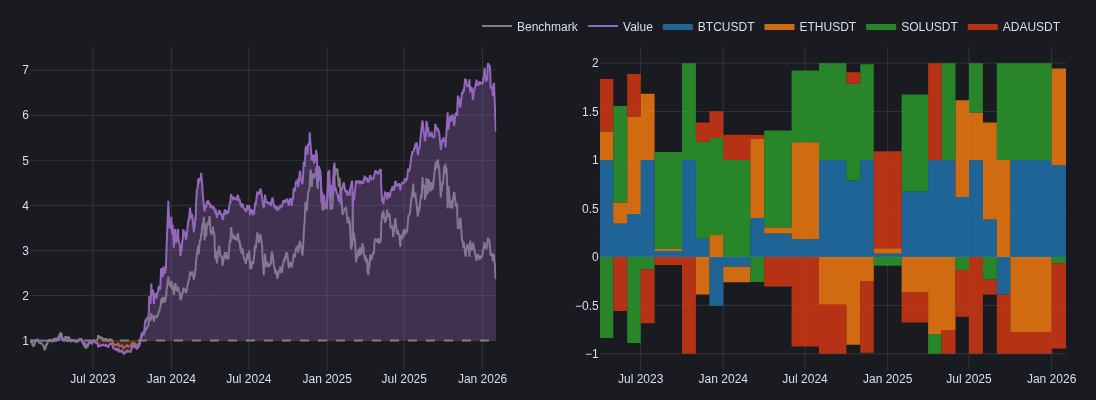

In [11]:
fig = vbt.make_subplots(rows=1, cols=2)
fig.update_layout(width=1000,height=400)
pf.plot_cumulative_returns(add_trace_kwargs=dict(row=1, col=1), fig=fig)
pfo.plot(add_trace_kwargs=dict(row=1, col=2), fig=fig)

So the Sharpe ratio $S_a=1.39$ is not ideal if we're chasing alpha (i.e. profitable strategy whether the market is bearish/bullish), but if we're just looking to increase our beta (increasing exposure to the market swings to capture the most price action) then this is reasonable. 

However, if we consider transction costs of $0.1\%$ of the amount traded, the story changes; we are actually less profitable with a decrease of $13\%$ in annualized returns (AR).

In [21]:
initial_weights = np.array([1 / len(data.symbols)] * len(data.symbols))
pfo = vbt.PortfolioOptimizer.from_pypfopt(
    prices=data.get("Close"),
    every="1M",
    weight_bounds=(-1, 1),
    objectives=["transaction_cost"],
    w_prev=initial_weights, 
    k=0.001,
    target="max_sharpe"
)

In [22]:
pf = pfo.simulate(data, freq="1d")
print(f"SR: {pf.sharpe_ratio:.3g}, MDD: {pf.max_drawdown:.3f}, AR: {pf.annualized_return:.3f}")

SR: 1.31, MDD: -0.362, AR: 0.664
